In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
import datetime
import random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from tqdm import tqdm
%matplotlib inline
# 常数定义
E = 210e9       # 杨氏模量 (Pa)
v = 0.3         # 泊松比
Thick = 0.003        # 厚度 (m)
High = 0.5        # 宽度 (m)
Length = 1.0         # 梁长 (m)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
x_vals = np.linspace(0.02, 0.92, 10)
y_vals = np.array([0.02, 0.25, 0.48])
xy_grid = np.array([[x, y] for y in y_vals for x in x_vals])
xy_grid = xy_grid[np.lexsort((xy_grid[:, 1], xy_grid[:, 0]))]
# 高斯过程参数
sigma = 1.0       # 方差幅度
length_scale = 0.2   # 平滑程度（越大越平滑）
kernel = sigma**2 * RBF(length_scale=length_scale)

gp = GaussianProcessRegressor(kernel=kernel)

n_samples = 1000
all_F = []
for i in tqdm(range(n_samples), desc="Generating GRF samples"):
    F_x_sample = gp.sample_y(xy_grid, n_samples=1, random_state=np.random.randint(0, 1e6))
    F_x_sample = F_x_sample / np.max(np.abs(F_x_sample)) * 2e-4
    all_F.append(F_x_sample.ravel())
    
all_F = np.array(all_F)
print('Scale: ',all_F.min(),' ~ ',all_F.max())
print('Shape: ', all_F.shape)

Generating GRF samples: 100%|██████████| 1000/1000 [00:00<00:00, 2571.39it/s]

Scale:  -0.0002  ~  0.0002
Shape:  (1000, 30)


In [3]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=100, depth=3):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(hidden, hidden), nn.Tanh()]
        layers.append(nn.Linear(hidden, out_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
        
class Modified_MLP_Block(nn.Module):
    def __init__(self, input_dim, hidden_channel, output_dim, hidden_size=4):
        super(Modified_MLP_Block, self).__init__()
        self.activation = nn.Tanh()
        self.encodeU = nn.Linear(input_dim, hidden_channel)
        self.encodeV = nn.Linear(input_dim, hidden_channel)
        self.In = nn.Linear(input_dim, hidden_channel)

        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_channel, hidden_channel) for _ in range(hidden_size)
        ])
        self.out = nn.Linear(hidden_channel, output_dim)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.constant_(m.bias, 0.0)
                
    def forward(self, x):
        U = self.activation(self.encodeU(x))
        V = self.activation(self.encodeV(x))
        Hidden = self.activation(self.In(x))

        for layer in self.hidden_layers:
            Z = self.activation(layer(Hidden))
            Hidden = (1 - Z) * U + Z * V

        x = self.out(Hidden)
        return x
        
class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden=100):
        super(DeepONet, self).__init__()
        self.branch_net = Modified_MLP_Block(branch_input_dim, hidden, hidden, hidden_size=3)
        self.trunk_net = Modified_MLP_Block(trunk_input_dim, hidden, hidden, hidden_size=3)

    def forward(self, B_in, T_in):
        B_out = self.branch_net(B_in)         # [batch, hidden]
        T_out = self.trunk_net(T_in)          # [batch, hidden]
        return (torch.sum(B_out * T_out, dim=-1, keepdim=True)) * T_in[:,0:1]

In [4]:
Col = xy_grid

X_train = np.zeros((1000 * len(Col), 33))
for i in range(1000):
    current_F = all_F[i, :]
    repeated_F = np.tile(current_F, (len(Col), 1))
    paired_data = np.hstack([repeated_F, Col, current_F.reshape(-1, 1)])
    start_idx = i * len(Col)
    end_idx = (i + 1) * len(Col)
    X_train[start_idx:end_idx, :] = paired_data

class Dataset(Dataset):
    def __init__(self, data, cur_device  ='cuda'):
        self.data = data
        self.device = cur_device
        
    def __getitem__(self, index):
        aB_data = self.data[index][:-3]
        aT_data = self.data[index][-3:-1]
        aW_data = self.data[index][-1:]
        aB_data = torch.tensor(aB_data, dtype=torch.float32, requires_grad=True)
        aT_data = torch.tensor(aT_data, dtype=torch.float32, requires_grad=True)
        aW_data = torch.tensor(aW_data, dtype=torch.float32, requires_grad=True)
        return aB_data, aT_data, aW_data
        
    def __len__(self):
        return len(self.data)
        
Train_Dataset = Dataset(X_train, cur_device = device)
Train_DataLoader = DataLoader(Train_Dataset, batch_size=10000, shuffle=True)
model = DeepONet(30,2,400).to(device)
# model.load_state_dict(torch.load(r"C:\Users\Fan\JupyterFile\DeepLearning\PINNs\PINNs_ElasticMechanics\test\piDeepONet_Beam_2d.pkl", weights_only=True))

In [5]:
def get_pde_loss(in_B, in_T, in_W):
    x, y = in_T[:,0:1], in_T[:,1:2]
    w_pre = model(in_B, torch.hstack((x,y)))
    dw_dx = torch.autograd.grad(w_pre, x, grad_outputs=torch.ones_like(w_pre), create_graph=True)[0]
    d2w_dx2 = torch.autograd.grad(dw_dx, x, grad_outputs=torch.ones_like(dw_dx), create_graph=True)[0]
    
    eps_x = in_W[:,0:1]
    
    pde_x = eps_x + 0.5 * Thick * d2w_dx2
    pde_residual = torch.mean(pde_x ** 2)
    return pde_residual
    
def get_bc_loss(in_B):
    b, _ = in_B.shape
    x0 = torch.zeros([b,1]).to(device).requires_grad_(True)
    y0 = (torch.rand([b,1]) * High).to(device).requires_grad_(True)
    T0 = torch.hstack((x0,y0))
    w0 = model(in_B, T0)
    dw_dx0 = torch.autograd.grad(w0, x0, grad_outputs=torch.ones_like(w0), create_graph=True)[0]
    return torch.mean(w0 ** 2) + torch.mean(dw_dx0 ** 2)

Epoch 0: PDE=3.9817e-07 | BC=1.0537e-04
Epoch 200: PDE=1.3215e-08 | BC=5.3687e-07
Epoch 400: PDE=7.6233e-09 | BC=4.0494e-08
Epoch 600: PDE=4.6070e-09 | BC=1.9577e-07
Epoch 800: PDE=2.4869e-09 | BC=2.5275e-07
Epoch 1000: PDE=1.7329e-09 | BC=1.8077e-07
Epoch 1200: PDE=1.1622e-09 | BC=1.1263e-07
Epoch 1400: PDE=9.4532e-10 | BC=8.3877e-08
Epoch 1600: PDE=8.4351e-10 | BC=9.4317e-08
Epoch 1800: PDE=7.9076e-10 | BC=5.4511e-08
Training Time:  3143.895011 s
Current learning rate: 7.69449752767131e-05


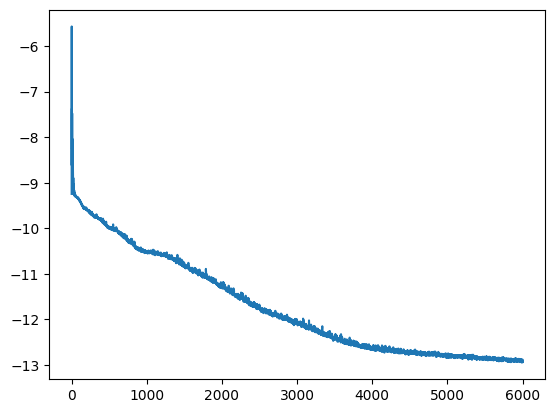

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.95)
epochs = 2000
start_time = datetime.datetime.now()
Loss = []
for epoch in range(epochs):
    epoch_pde_loss = 0
    epoch_bc_loss = 0
    for i, (B_data, T_data, W_data) in enumerate(Train_DataLoader):
        B_data = B_data.to(device)
        T_data = T_data.to(device)
        W_data = W_data.to(device)
        optimizer.zero_grad()
        loss_pde = get_pde_loss(B_data, T_data, W_data)
        loss_bc = get_bc_loss(B_data)
        loss = loss_pde * 1e4 + loss_bc
        epoch_pde_loss += loss_pde.item()
        epoch_bc_loss += loss_bc.item()
        Loss.append(loss.item())
        loss.backward()
        optimizer.step()
    scheduler.step()
        
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: PDE={epoch_pde_loss:.4e} | BC={epoch_bc_loss:.4e}")
end_time = datetime.datetime.now()
running_time = end_time - start_time
print("Training Time: ", running_time.total_seconds(), "s")
print("Current learning rate:", optimizer.param_groups[0]['lr'])
plt.plot(np.log(Loss))
plt.show()

In [22]:
def get_Test(name):
    test_data = pd.read_csv('F:\\DeepLearningDataset\\Beam\\Beam2d\\'+name+'.csv')
    exx = np.array(test_data['exx']).ravel()
    X = np.array(test_data[['x','y']])
    test_B_data = torch.tensor(np.repeat(exx.reshape(1,-1),X.shape[0],axis=0), dtype=torch.float32, requires_grad=True).to(device)
    test_T_data = torch.tensor(X, dtype=torch.float32, requires_grad=True).to(device)
    
    w_pre = model(test_B_data, test_T_data).cpu().detach().numpy().flatten()
    
    test_x = np.array(test_data['x'])
    test_y = np.array(test_data['y'])
    w_ex = np.array(test_data['w'])
    print(f'Error: {np.mean((w_pre - w_ex)**2)}')
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(test_x, test_y, w_ex, color='blue', marker='s', label='Exact', s=40)
    ax.scatter(test_x, test_y, w_pre, color='gold', marker='o', label='Pre', s=20)

    y_unique = [0.02, 0.25, 0.48]
    for y_val in y_unique:
        idx = np.where(np.isclose(test_y, y_val))[0]
        sorted_idx = idx[np.argsort(test_x[idx])]
        x_line = test_x[sorted_idx]
        y_line = test_y[sorted_idx]
        ex_line = w_ex[sorted_idx]
        pre_line = w_pre[sorted_idx]
    
        ax.plot(x_line, y_line, ex_line, color='blue', linewidth=1)
        ax.plot(x_line, y_line, pre_line, color='gold', linewidth=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('w(x, y)')
    ax.set_title('Comparison of Exact and Predicted Displacements')
    ax.legend()
    plt.tight_layout()
    plt.show()

Error: 6.711455134314366e-08


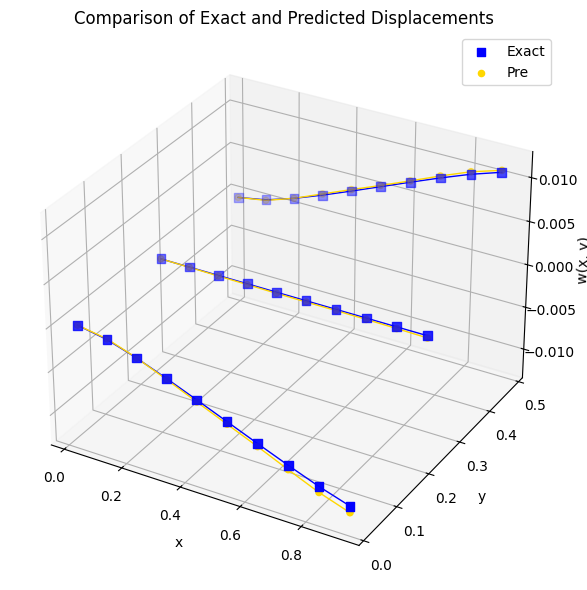

Error: 2.0071149041978112e-07


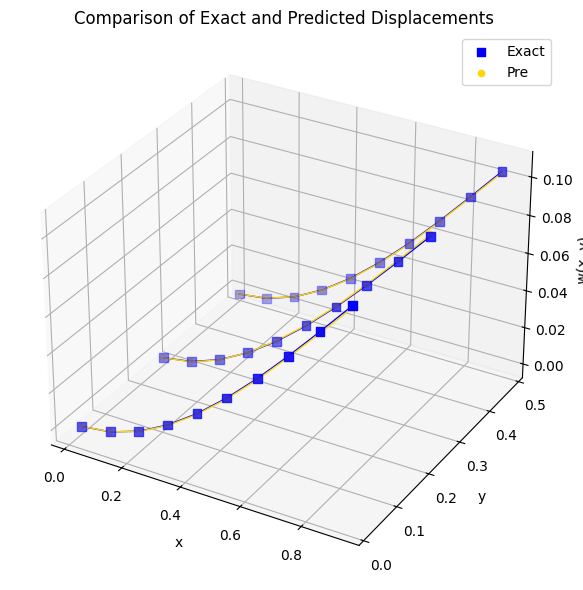

Error: 7.260491345429004e-06


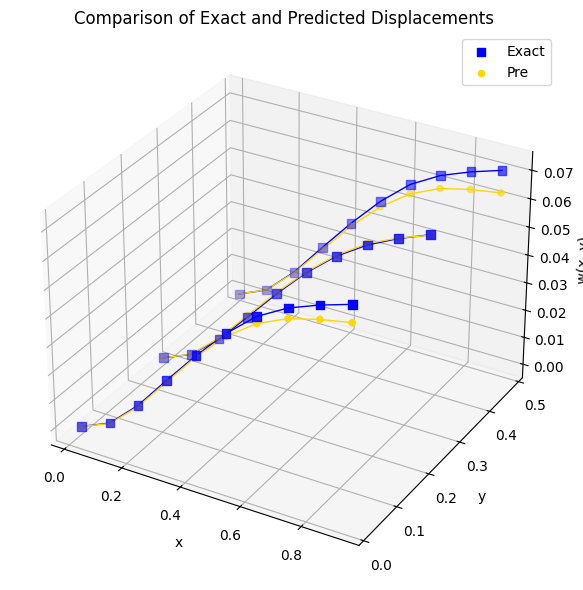

Error: 0.00016172445542196725


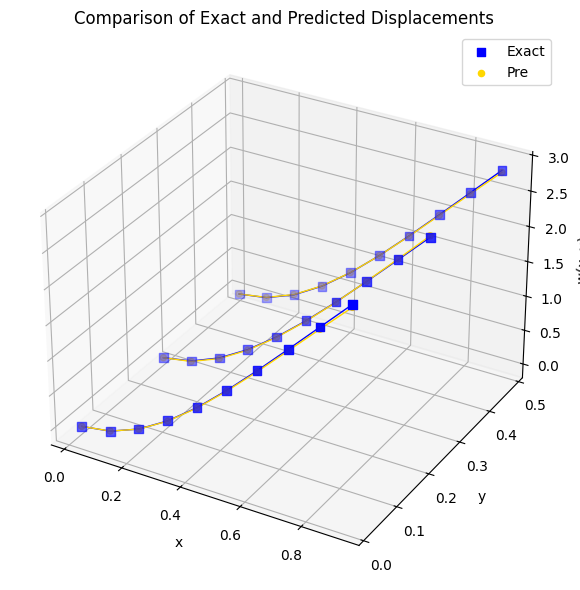

Error: 0.0005850655685394384


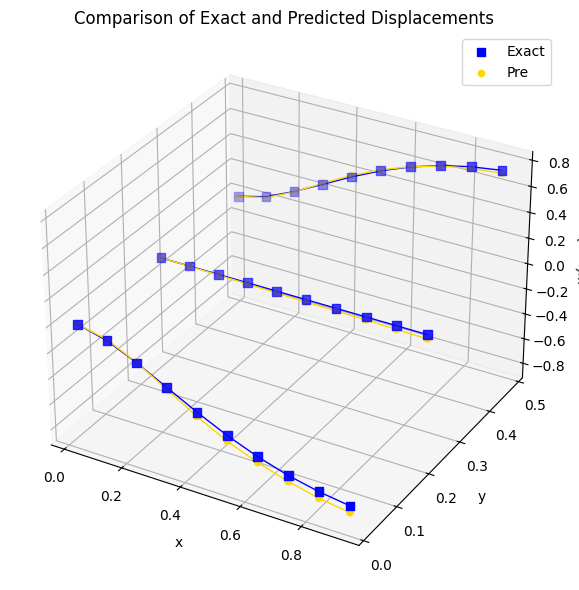

In [23]:
get_Test('beam1')
get_Test('beam2')
get_Test('beam3')
get_Test('beam4')
get_Test('beam5')